In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

In [2]:
breast_cancer = load_breast_cancer()
X, y = breast_cancer.data, breast_cancer.target
idx = X[:,0] > np.quantile(X[:,0], .5)
X_train, X_test, y_train, y_test = (
    X[idx], X[np.logical_not(idx)], 
    y[idx], y[np.logical_not(idx)],
)

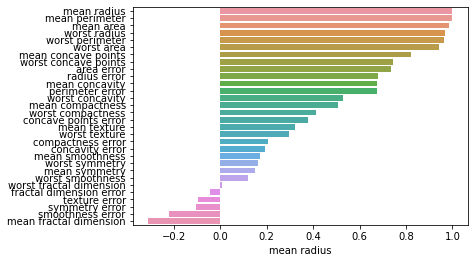

In [3]:
col = breast_cancer.feature_names[0]
corr_df = pd.DataFrame(columns=breast_cancer.feature_names, data=X).corr()
corr_df = corr_df.sort_values(col, ascending=False)
sns.barplot(corr_df[col], corr_df.index)
plt.show()

In [5]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
print('Train score: % .4f' % balanced_accuracy_score(y_train, clf.predict(X_train)))
print('Test score: % .4f' % balanced_accuracy_score(y_test, clf.predict(X_test)))

Train score:  0.9498
Test score:  0.7628


In [6]:
g = lambda y_pred: balanced_accuracy_score(y_train, y_pred)
explainer = gshap.KernelExplainer(clf.predict, X_train, g)
gshap_values_train = explainer.gshap_values(X_train, nsamples=100)

In [7]:
g_comparison, g_background = explainer.compare(X_train, bootstrap_samples=100)
print(g_comparison)
print(g_background)
print(gshap_values_train.sum())

0.949812734082397
0.501594929415154
0.4166450590607893


In [8]:
g = lambda y_pred: balanced_accuracy_score(y_test, y_pred)
explainer = gshap.KernelExplainer(clf.predict, X_train, g)
gshap_values_test = explainer.gshap_values(X_test, nsamples=100)

In [9]:
g_comparison, g_background = explainer.compare(X_test, bootstrap_samples=100)
print(g_comparison)
print(g_background)
print(gshap_values_test.sum())

0.7628402107111502
0.4941176470588234
0.24644424934152767


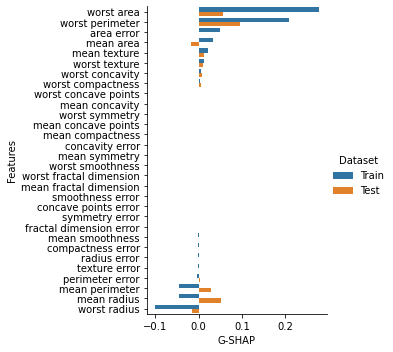

In [10]:
df = pd.DataFrame({
    'Features': breast_cancer.feature_names,
    'Train': gshap_values_train,
    'Test': gshap_values_test,
})
df = df.sort_values('Train', ascending=False)
df = pd.melt(
    df, 
    id_vars='Features',
    value_vars=['Train', 'Test'],
    var_name='Dataset',
    value_name='G-SHAP',
)
sns.catplot(
    x='G-SHAP',
    y='Features',
    hue='Dataset',
    data=df,
    kind='bar',
    orient='h'
)
plt.show()